Folhas disponíveis no arquivo:
['DadosQueimadas']
Dados de queimadas:
             DataHora  Satelite    Pais       Estado              Municipio  \
0 2023-01-02 17:11:00  AQUA_M-T  Brasil  MATO GROSSO               CÃCERES   
1 2023-01-02 17:11:00  AQUA_M-T  Brasil  MATO GROSSO                POCONÃ‰   
2 2023-01-02 17:11:00  AQUA_M-T  Brasil  MATO GROSSO                POCONÃ‰   
3 2023-01-02 17:13:00  AQUA_M-T  Brasil    MARANHÃƒO  AMARANTE DO MARANHÃƒO   
4 2023-01-02 17:13:00  AQUA_M-T  Brasil    MARANHÃƒO          TASSO FRAGOSO   

      Bioma  DiaSemChuva  Precipitacao  RiscoFogo   Latitude  Longitude    FRP  
0  Pantanal          2.0          2.25       0.03 -1752869.0 -5766138.0   82.4  
1  Pantanal          0.0          0.63       0.07 -1761373.0 -5748255.0   63.7  
2  Pantanal          0.0          0.56       0.06 -1761592.0 -5747493.0  101.4  
3   Cerrado          0.0          0.00       0.08  -545368.0 -4683593.0   22.2  
4   Cerrado          0.0          0.00       0.02 

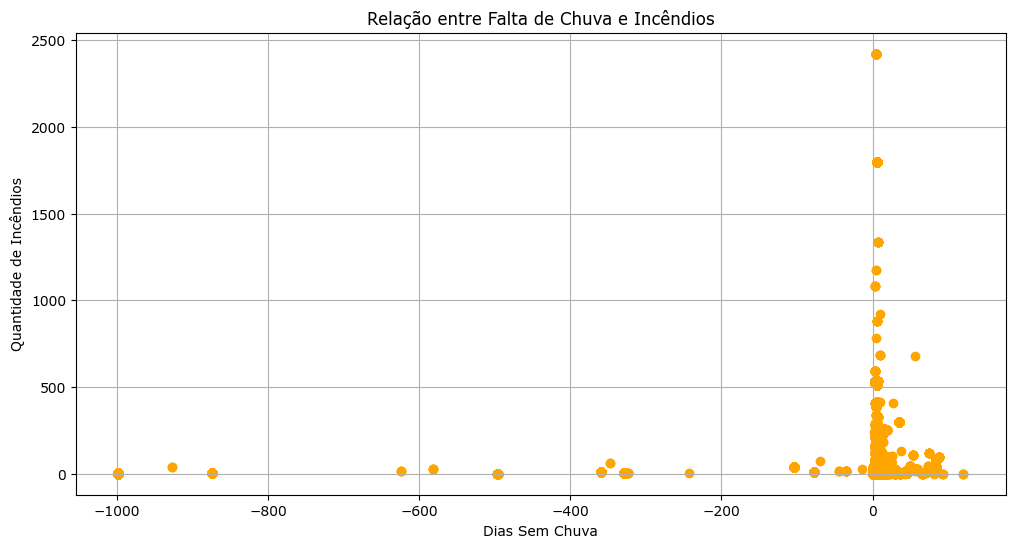

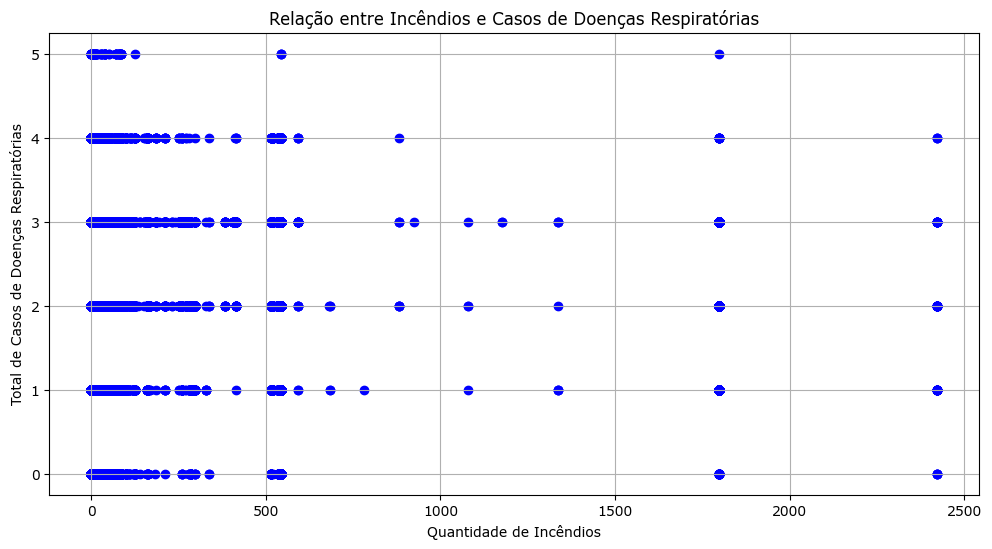

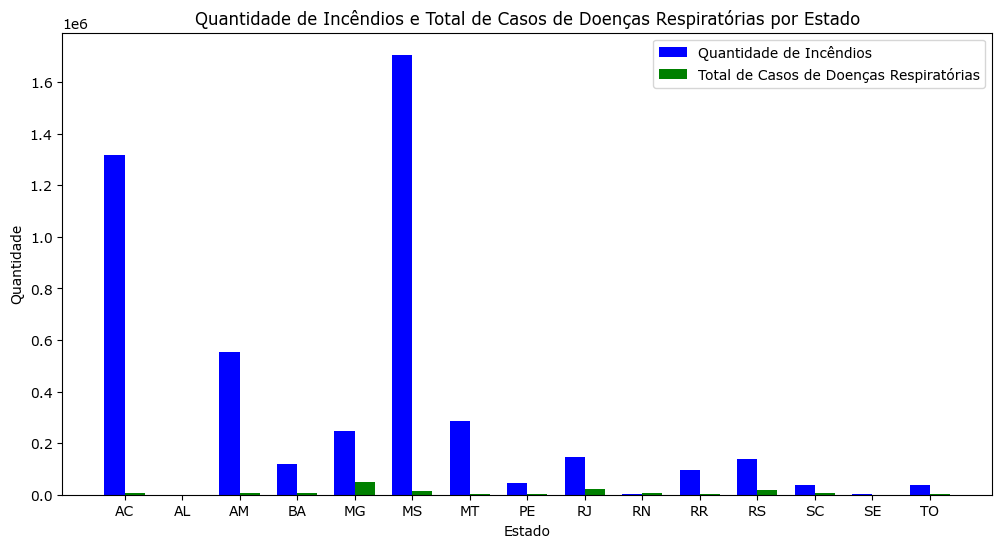

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import unidecode  # Certifique-se de que o unidecode está instalado com "pip install unidecode"
import re

# Dicionário de conversão de estados para siglas
estado_para_sigla = {
    "ACRE": "AC", "ALAGOAS": "AL", "AMAPÁ": "AP", "AMAZONAS": "AM",
    "BAHIA": "BA", "CEARÁ": "CE", "DISTRITO FEDERAL": "DF", "ESPÍRITO SANTO": "ES",
    "GOIÁS": "GO", "MARANHÃO": "MA", "MATO GROSSO": "MT", "MATO GROSSO DO SUL": "MS",
    "MINAS GERAIS": "MG", "PARÁ": "PA", "PARAÍBA": "PB", "PARANÁ": "PR",
    "PERNAMBUCO": "PE", "PIAUÍ": "PI", "RIO DE JANEIRO": "RJ", "RIO GRANDE DO NORTE": "RN",
    "RIO GRANDE DO SUL": "RS", "RONDÔNIA": "RO", "RORAIMA": "RR", "SANTA CATARINA": "SC",
    "SÃO PAULO": "SP", "SERGIPE": "SE", "TOCANTINS": "TO"
}

# Função para normalizar textos (remover acentos e caracteres especiais)
def normalize_text(text):
    text = unidecode.unidecode(text.strip().upper())
    return re.sub(r'[^A-Z\s]', '', text)  # Remove caracteres indesejados

# Verificar o conteúdo do arquivo e as abas disponíveis
xls = pd.ExcelFile("DadosQueimadas.xlsx")
print("Folhas disponíveis no arquivo:")
print(xls.sheet_names)

# Carregar os dados da aba correta
queimadas = pd.read_excel("DadosQueimadas.xlsx")  # Ajuste 'NomeDaAba' se necessário
print("Dados de queimadas:")
print(queimadas.head())  # Exibir as primeiras linhas do DataFrame

# Continuar com o carregamento dos dados de saúde
saude = pd.read_excel("DadosSaude.xlsx")

# Normalizar e corrigir municípios e estados nos dados de queimadas
queimadas['Municipio'] = queimadas['Municipio'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].map(estado_para_sigla)
queimadas = queimadas.dropna(subset=['Estado', 'Municipio'])

# Normalizar colunas de município e estado no dataset de saúde
saude['ID_MUNICIP'] = saude['ID_MUNICIP'].apply(normalize_text)
saude['SG_UF_NOT'] = saude['SG_UF_NOT'].apply(normalize_text)  # Nome correto da coluna

# Criar uma coluna de total de sintomas respiratórios no DataFrame de saúde
saude['Total_Casos_Doencas_Respiratorias'] = saude[['TOSSE', 'DISPNEIA', 'DESC_RESP', 'ASMA', 'PNEUMOPATI']].apply(
    lambda x: (x == 1).sum(), axis=1
)

# Adicionar uma coluna para contar cada ocorrência de incêndio
queimadas['Incendios_Contagem'] = 1

# Agrupar os dados de queimadas por Município e Estado, apenas somando a contagem de incêndios e média de dias sem chuva
queimadas_agrupadas = queimadas.groupby(['Municipio', 'Estado']).agg({
    'Incendios_Contagem': 'sum',  # Contagem de incêndios
    'DiaSemChuva': 'mean'          # Média de dias sem chuva
}).reset_index()

# Verificar dados antes da mesclagem
print("Dados de queimadas agrupadas:")
print(queimadas_agrupadas.head())

# Exibir dados de saúde
print("Dados de saúde:")
print(saude[['ID_MUNICIP', 'SG_UF_NOT', 'Total_Casos_Doencas_Respiratorias']].head())

# Mesclar os dados de saúde com os dados agregados de queimadas
dados_combinados = pd.merge(saude, queimadas_agrupadas, left_on=['ID_MUNICIP', 'SG_UF_NOT'], right_on=['Municipio', 'Estado'], how='inner')

# Calcular a correlação entre falta de chuva e casos de doenças respiratórias
correlacao_falta_chuva_doencas = dados_combinados['DiaSemChuva'].corr(dados_combinados['Total_Casos_Doencas_Respiratorias'])
print(f"Correlação entre falta de chuva e casos de doenças respiratórias: {correlacao_falta_chuva_doencas}")

# Exibir estatísticas descritivas das colunas relevantes
print(dados_combinados[['DiaSemChuva', 'Incendios_Contagem', 'Total_Casos_Doencas_Respiratorias']].describe())

# Gráfico de dispersão: Relação entre falta de chuva e incêndios
plt.figure(figsize=(12, 6))
plt.scatter(dados_combinados['DiaSemChuva'], dados_combinados['Incendios_Contagem'], color='orange')
plt.title('Relação entre Falta de Chuva e Incêndios')
plt.xlabel('Dias Sem Chuva')
plt.ylabel('Quantidade de Incêndios')
plt.grid()
plt.show()

# Gráfico de dispersão: Relação entre incêndios e casos de doenças respiratórias
plt.figure(figsize=(12, 6))
plt.scatter(dados_combinados['Incendios_Contagem'], dados_combinados['Total_Casos_Doencas_Respiratorias'], color='blue')
plt.title('Relação entre Incêndios e Casos de Doenças Respiratórias')
plt.xlabel('Quantidade de Incêndios')
plt.ylabel('Total de Casos de Doenças Respiratórias')
plt.grid()
plt.show()

# Gráfico de barras: Total de Casos de Doenças Respiratórias e Incêndios por Estado
dados_estado = dados_combinados.groupby('Estado').agg({
    'Incendios_Contagem': 'sum',  # Soma total de incêndios por estado
    'Total_Casos_Doencas_Respiratorias': 'sum'  # Soma total de casos de doenças por estado
}).reset_index()

# Configurar o gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Criar as barras
bar_width = 0.35
index = range(len(dados_estado))

# Barras para Incêndios
bars1 = ax.bar(index, dados_estado['Incendios_Contagem'], bar_width, label='Quantidade de Incêndios', color='b')

# Barras para Casos de Doenças Respiratórias
bars2 = ax.bar([i + bar_width for i in index], dados_estado['Total_Casos_Doencas_Respiratorias'], bar_width, label='Total de Casos de Doenças Respiratórias', color='g')

# Adicionar rótulos e título
ax.set_xlabel('Estado')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade de Incêndios e Total de Casos de Doenças Respiratórias por Estado')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(dados_estado['Estado'])
ax.legend()

# Exibir o gráfico
